<a href="https://colab.research.google.com/github/kjsandbrink/hip-rlday/blob/main/HIP_DeepRLDay_2023_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to the algorithms & agents reinforcement learning workshop!
### HIP Lab Deep RL Day 2023

This notebook has as goal to introduce basic concepts about algorithms & agents in (policy gradient) reinforcement learning. We will begin by creating a small sample environment, creating an agent, and then taking a look at the training loop. We start out by using simple *REINFORCE*, before incorporating a *baseline*, and finally constructing an *advantage actor-critic (A2C).*

The environment we will build is a correlated bandit task.

In [ ]:
import numpy as np
import math
import torch
from torch import nn
from torch.distributions import Categorical
from collections import deque
import matplotlib.pyplot as plt

In [ ]:
class TwoArmedGaussianBandit:

    def __init__(self, mean_mag, reward_var, n_steps, center=0):
        ''' Initializes correlated two-armed bandit task for bandits that have the same variance but opposing means

        Arguments
        ---------
        mean_mag : float, variance in means for distribution from which bandit arm means will be drawn (centered around 0)
        reward_var : float, variance for distribution on each arm mean from which reward will be sampled
        n_steps : int, number of steps in an episode
        center : float, number around which arms are centered
        '''
        self.mean_mag = mean_mag
        self.reward_var = reward_var
        self.n_steps = n_steps
        self.center = center

    def reset(self):
        ''' Resamples new bandit arm probabilities, to be called at the beginning of every episode'''

        # sample mean rewards
        self.mean = [self.mean_mag + self.center, -self.mean_mag + self.center]
        np.random.shuffle(self.mean)

        ## reset counter_steps to 0
        self.counter_steps = 0

        return [0]

    def step(self, action):
        """
        Arguments
        ---------
        action (int): the selected action.

        Returns
        -------
        observation : np.array; here, only contains the reward
        reward : float
        done : bool, True: the episode has terminated; False: otherwise
        info : dict info for debugging
        """

        reward = np.random.normal(self.mean[action], math.sqrt(self.reward_var))

        self.counter_steps += 1
        done = (self.counter_steps == self.n_steps)
        return np.array([reward]), reward, done, self.mean

As you can see, the environment has a start_new_episode and a step function, which we call when the agent interacts with the environment.

We next define our REINFORCE actor network. This network is copied from networks.py from the DeepRLDay GitHub repository we will be using if you attend the evening session.

In [ ]:
class PolicyRNN(nn.Module):

    def __init__(self, n_actions, n_inputs, hidden_size=32):

        super().__init__()
        self.n_actions = n_actions
        self.n_inputs = n_inputs
        self.hidden_size = hidden_size
        torch.manual_seed(1)
        self.initialize_model()

    def initialize_model(self):

        self.lstm = nn.LSTMCell(self.n_inputs, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.n_actions)
        self.logits = nn.LogSoftmax(dim=0)

    def forward(self, x, lstm_hidden = None):

        if lstm_hidden is None:
            lstm_h, lstm_c = self.lstm(x)
        else:
            lstm_h, lstm_c = self.lstm(x, lstm_hidden)
        out = self.out(lstm_h)
        logits = self.logits(out)

        return logits, (lstm_h, lstm_c)

Now there we have a network that can approximate our policy, we are ready to create an agent class so that we can look at each of the components in turn. The agent class has some methods missing completely and others only instantiated partially - can you complete the missing components?

In [ ]:
class ReinforceAgent:

    def __init__(self, n_actions, n_inputs, hidden_size, learning_rate, gamma = 0.99):

        self.gamma = gamma
        self.n_actions = n_actions
        self.policy = PolicyRNN(n_actions, n_inputs, hidden_size)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr = learning_rate)
        self.history = []
        self.batch_losses = []
        self.episode_rewards = []
        self.episode_log_probs = []

    def choose_action(self, observation):
        ''' Selects an action by using the policy network. Can you fill this on?

        Arguments
        ---------
        observation : np.array [1, n_features]

        Returns
        -------
        action : int between 0 and n_action - 1
        '''

        ### EXERCISE 1: The network specified above returns log probabilities ("logits") corresponding to the agent policy.
        ### Can you use this probability to sample an action? Usually, this is done using the torch "Categorical"
        ### distribution object which is already imported above
        ### Remember that we need to save the log probability corresponding to our chosen action afterward -- append this to episode_log_probs

        state = torch.tensor(observation, dtype=torch.float32)
        log_probs, self.lstm_hidden = self.policy(state, self.lstm_hidden)
        action_probs = Categorical(logits = log_probs)
        action = action_probs.sample()

        self.episode_log_probs.append(action_probs.log_prob(action))

        return action.detach().numpy().item()

    def store_transition(self, observation, action, reward, next_observation):
        self.history.append((observation, action, reward, next_observation))
        self.episode_rewards.append(reward)

    def reset(self):
        self.lstm_hidden = None

        ## reset self.episode_rewards and self.episode_log_probs to 0
        self.episode_rewards = []
        self.episode_log_probs = []

    def calculate_episode_loss(self):
        ''' This function is called at the end of an episode to calculate the loss
        using self.episode_rewards and self.episode_log_probs.
        The loss is then appended to self.batch_losses and self.episode_rewards
        and self.episode_log_probs reset.

        Can you fill this in?
        '''

        R = 0
        #policy_loss = []

        ## compute cumulative rewards from each time point (=returns)
        returns = deque()
        for r in self.episode_rewards[::-1]:

            #### EXERCISE 2: We are looping through our returns backwards step-by-step
            #### in order to compute the cumulative rewards from each time point.
            #### We then prepend these to the deque.
            #### Can you compute cumulative returns at each step and save them to "R"?

            #### YOUR CODE HERE

            R = r + self.gamma * R

            returns.appendleft(R)
        returns = torch.tensor(returns)

        ## normalize rewards, with eps to avoid div by zero
        returns = (returns - returns.mean()) / (returns.std() + np.finfo(np.float32).eps.item())

        ## compute policy gradient

        #### EXERCISE 3: Now there we have both the cumulative reward from each time point as well as our episode_log_probs,
        #### we compute our policy gradient loss for the episode and save it to policy_loss.
        #### Can you do this keeping in mind the formulas learned from Aniruddh's lecture?

        episode_log_probs = torch.stack(self.episode_log_probs)
        policy_loss = - (episode_log_probs * returns).sum()

        self.batch_losses.append(policy_loss)

        return policy_loss.detach().item()

    def batch_learn(self):
        ''' This function performs a gradient update based on the batched episodes.
        At the end, self.batch_losses is reset to an empty list.

        Arguments
        ---------
        self

        Returns
        -------
        batch_loss : float, loss over the current batch
        '''

        ## take optimizer step
        self.optimizer.zero_grad()
        batch_loss = torch.stack(self.batch_losses).mean()
        batch_loss.backward()
        self.optimizer.step()

        self.batch_losses = []

        return batch_loss.detach().item()

Now, let's put it all together in a training loop! This loop has all the pieces filled in already, so you should just be able to run it.

In [ ]:
# %% PARAMETERS
n_steps = 20
n_episodes = 10000
#n_episodes = 100
batch_size = 50
hidden_size = 16
learning_rate = 1e-3
gamma = 0.99 #discount factor

# %% INITIALIZATIONS
env = TwoArmedGaussianBandit(10, 0.1, n_steps)
agent = ReinforceAgent(n_actions = 2, n_inputs = 1, hidden_size = hidden_size,  learning_rate = learning_rate, gamma = gamma)
score_history = []
pg_losses = []

for i in range(n_episodes):

    done = False
    score = 0
    observation = env.reset()
    agent.reset()

    while not done:

        ### EXERCISE 4: The next functions encode the interactions between agent and the environment.
        ### The agent needs to choose an action, interact with the environment, store the transition,
        ### and finally update the observation and score variables.
        ### Most of these pieces already exist in the module functions - can you put them all together?

        ### YOUR CODE HERE

        action = agent.choose_action(observation)
        next_observation, reward, done, info = env.step(action)
        agent.store_transition(observation, action, reward, next_observation)
        observation = next_observation

        score += reward

    score_history.append(score)
    episode_loss = agent.calculate_episode_loss()
    #print(episode_loss)
    pg_losses.append(episode_loss)
    avg_score = np.mean(score_history[-50:])
    avg_loss = np.mean(pg_losses[-50:])

    if i % (n_episodes // 10) == 0:
      print('episode ', i, 'score  %.1f' % score, 'avg score %.1f' % avg_score, 'loss %.1f' % episode_loss, 'avg_loss %.1f' % avg_loss)

    ### call learning function
    if i!=0 and i % batch_size == 0:
      agent.batch_learn()

episode  0 score  79.3 avg score 79.3 loss -0.4 avg_loss -0.4
episode  1000 score  77.6 avg score 4.5 loss 0.5 avg_loss 0.1
episode  2000 score  -60.0 avg score 6.2 loss -0.5 avg_loss -0.0
episode  3000 score  -20.4 avg score 1.5 loss 0.7 avg_loss 0.1
episode  4000 score  79.1 avg score 17.9 loss -1.2 avg_loss -0.2
episode  5000 score  -98.9 avg score 25.5 loss -0.8 avg_loss 0.1
episode  6000 score  101.7 avg score 40.2 loss 3.8 avg_loss 0.3
episode  7000 score  178.7 avg score 48.0 loss 3.7 avg_loss 0.2
episode  8000 score  40.4 avg score 50.0 loss -2.2 avg_loss -0.7
episode  9000 score  198.4 avg score 76.9 loss 1.1 avg_loss -0.1


Now there we're done with the training loop, let's plot our progress! This part is already done so you should just be able to run the code block.

Text(0, 0.5, 'Losses')

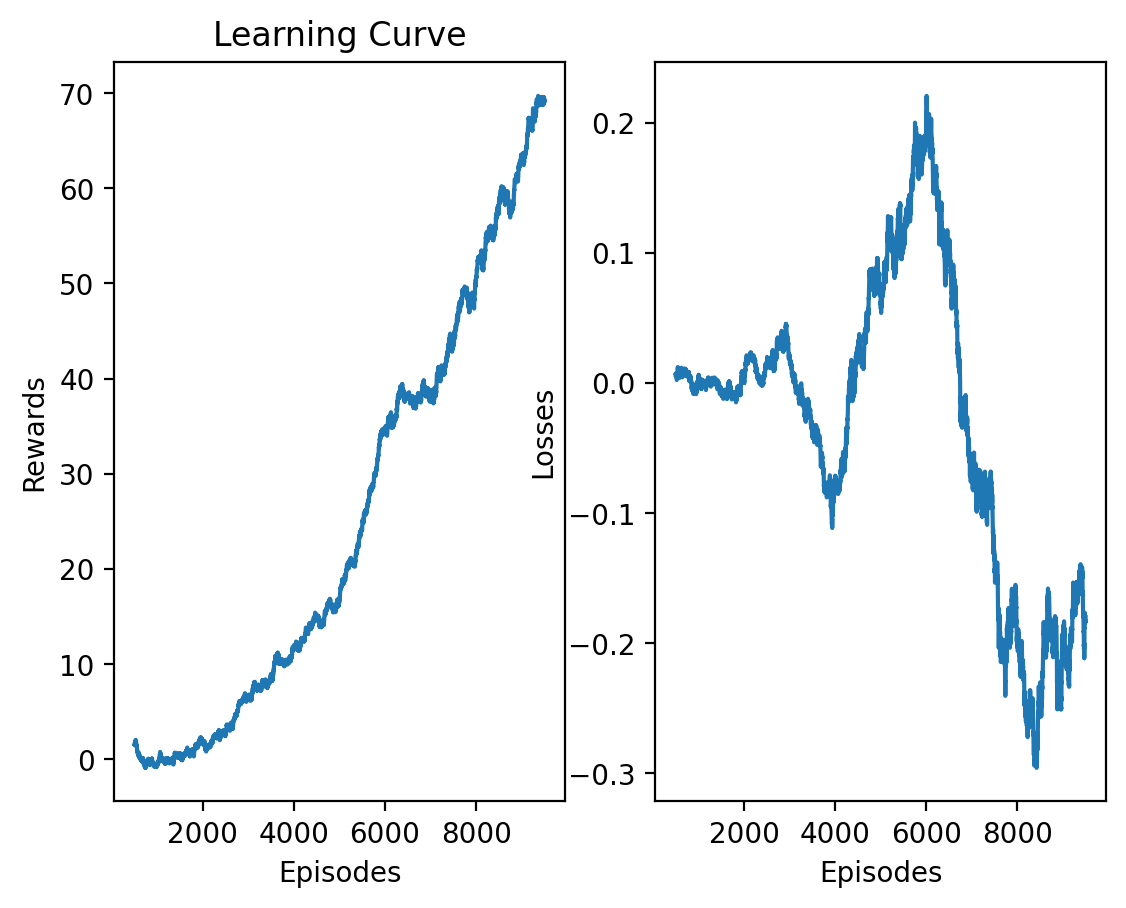

In [ ]:
# %% PLOT LEARNING CURVE
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='all', dpi=200)

## smooth rewards if necessary (moving average)
smoothing_window = n_episodes // 10
smoothed_rewards = np.convolve(score_history, np.ones(smoothing_window)/smoothing_window, mode='valid')
smoothed_losses = np.convolve(pg_losses, np.ones(smoothing_window)/smoothing_window, mode='valid')
episodes = np.array(range(n_episodes))[smoothing_window//2:-smoothing_window//2+1]

ax1.plot(episodes, smoothed_rewards)

ax1.set_title("Learning Curve")
ax1.set_xlabel("Episodes")
ax1.set_ylabel("Rewards")

ax2.plot(episodes, smoothed_losses)
ax2.set_xlabel("Episodes")
ax2.set_ylabel("Losses")

# REINFORCE with baseline

Sometimes, we encounter environments where the rewards are not neatly distributed around 0. In that case, it can be useful to re-center our rewards around 0 by introducing a baseline into our rewards function, which we will do in this section. As long as the baselines we use are only a function of the state and not of the action that we take they never perturb the equilibirum solution! In this section, we will look at constant baselines, but in the next section we will build on this to explore adaptive baselines that we can integrate by using a learned critic.

Let's start by taking a look at what happens when we use the regular REINFORCE agent on an off-centered environment. The training loop below contains the same blanks as the one above, so feel free to copy in your solutions from there...

In [ ]:
# %% PARAMETERS
n_steps = 20
n_episodes = 10000
batch_size = 50
hidden_size = 16
learning_rate = 1e-3
gamma = 0.99 #discount factor

# %% INITIALIZATIONS
env = TwoArmedGaussianBandit(5, 0.1, n_steps, center=10) ## this time, the environment is off-center
agent = ReinforceAgent(n_actions = 2, n_inputs = 1, hidden_size = hidden_size,  learning_rate = learning_rate, gamma = gamma)
score_history = []
pg_losses = []

for i in range(n_episodes):

    done = False
    score = 0
    observation = env.reset()
    agent.reset()

    while not done:
        action = agent.choose_action(observation)
        next_observation, reward, done, info = env.step(action)
        agent.store_transition(observation, action, reward, next_observation)
        observation = next_observation
        score += reward

    score_history.append(score)
    episode_loss = agent.calculate_episode_loss()
    pg_losses.append(episode_loss)
    avg_score = np.mean(score_history[-50:])
    avg_loss = np.mean(pg_losses[-50:])

    if i % (n_episodes // 10) == 0:
      print('episode ', i, 'score  %.1f' % score, 'avg score %.1f' % avg_score, 'loss %.1f' % episode_loss, 'avg_loss %.1f' % avg_loss)

    ### call learning function after each batch
    if i!=0 and i % batch_size == 0:

      ### EXERCISE 5: Call the learn function while entering in an appropriate baseline

      agent.batch_learn()

episode  0 score  241.3 avg score 241.3 loss -0.3 avg_loss -0.3
episode  1000 score  169.9 avg score 201.9 loss -0.1 avg_loss 0.0
episode  2000 score  228.8 avg score 204.0 loss 0.0 avg_loss -0.0
episode  3000 score  208.5 avg score 201.2 loss -0.4 avg_loss -0.0
episode  4000 score  179.7 avg score 196.3 loss -0.2 avg_loss -0.0
episode  5000 score  248.7 avg score 199.7 loss -0.6 avg_loss -0.0
episode  6000 score  198.8 avg score 197.6 loss 0.4 avg_loss 0.1
episode  7000 score  191.0 avg score 200.9 loss -0.2 avg_loss 0.0
episode  8000 score  199.8 avg score 195.4 loss 0.3 avg_loss 0.0
episode  9000 score  241.1 avg score 199.7 loss 0.3 avg_loss -0.0


Text(0, 0.5, 'Losses')

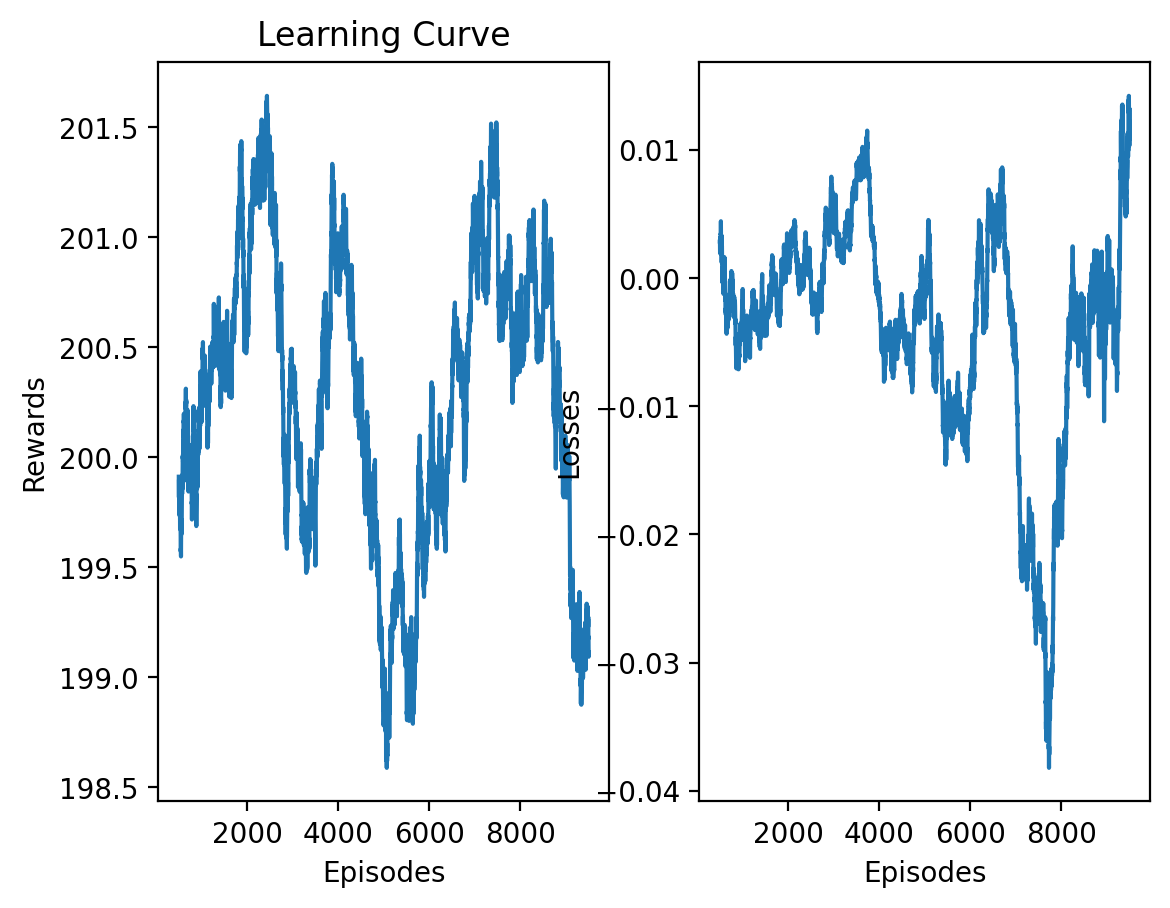

In [ ]:
# %% PLOT LEARNING CURVE
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='all', dpi=200)

## smooth rewards if necessary (moving average)
smoothing_window = n_episodes // 10
smoothed_rewards = np.convolve(score_history, np.ones(smoothing_window)/smoothing_window, mode='valid')
smoothed_losses = np.convolve(pg_losses, np.ones(smoothing_window)/smoothing_window, mode='valid')
episodes = np.array(range(n_episodes))[smoothing_window//2:-smoothing_window//2+1]

ax1.plot(episodes, smoothed_rewards)

ax1.set_title("Learning Curve")
ax1.set_xlabel("Episodes")
ax1.set_ylabel("Rewards")

ax2.plot(episodes, smoothed_losses)
ax2.set_xlabel("Episodes")
ax2.set_ylabel("Losses")

Now, let's try to fix this by incorporating an agent into our baseline!

The agent below inherits from ReinforceAgent. Some of the blanks you can fill in from part 1, but you will need to add an additional part in calculate_episode_loss! Think about it: What baseline do you think makes the most sense to enter for an off-center, correlated bandit task?


In [ ]:
class ReinforceWithBaselineAgent(ReinforceAgent):

    def calculate_episode_loss(self, baseline):
        ''' This function is called at the end of an episode to calculate the loss
        using self.episode_rewards and self.episode_log_probs.
        The loss is then appended to self.batch_losses and self.episode_rewards
        and self.episode_log_probs reset.

        Arguments
        ---------
        baseline : float, the baselines to compute

        '''

        R = 0

        ## compute cumulative rewards from each time point (=returns)
        returns = deque()
        for r in self.episode_rewards[::-1]:

            #### EXERCISE 1: We are looping through our returns backwards step-by-step
            #### in order to compute the cumulative rewards from each time point.
            #### We then prepend these to the deque.
            #### Can you compute cumulative returns at each step and save them to "R"?

            #### YOUR CODE HERE

            R = r + self.gamma * R

            #### EXERCISE 2: Now, substract the baseline from the returns in order to re-center the results around 0.

            #### YOUR CODE HERE

            R -= baseline

            returns.appendleft(R)
        returns = torch.tensor(returns)

        ## normalize rewards, with eps to avoid div by zero
        returns = (returns - returns.mean()) / (returns.std() + np.finfo(np.float32).eps.item())

        ## convert episode_log_probs to tensor (remember that this contains the log probabilities corresponding to the actions we took)
        episode_log_probs = torch.stack(self.episode_log_probs)

        policy_loss = - (episode_log_probs * returns).sum()

        self.batch_losses.append(policy_loss)

        return policy_loss.detach().item()

In [ ]:
# %% PARAMETERS
n_steps = 20
n_episodes = 20000
batch_size = 50
hidden_size = 16
learning_rate = 1e-3
gamma = 0.99 #discount factor

# %% INITIALIZATIONS
env = TwoArmedGaussianBandit(5, 0.1, n_steps, center=10) ## this time, the environment is off-center
agent = ReinforceWithBaselineAgent(n_actions = 2, n_inputs = 1, hidden_size = hidden_size,  learning_rate = learning_rate, gamma = gamma)
score_history = []
pg_losses = []

for i in range(n_episodes):

    done = False
    score = 0
    observation = env.reset()
    agent.reset()

    while not done:
        action = agent.choose_action(observation)
        next_observation, reward, done, info = env.step(action)
        agent.store_transition(observation, action, reward, next_observation)
        observation = next_observation
        score += reward

    score_history.append(score)

    ### EXERCISE 5: Call the calculate_episode_loss function while entering in an appropriate baseline

    episode_loss = agent.calculate_episode_loss(baseline=10)

    pg_losses.append(episode_loss)
    avg_score = np.mean(score_history[-50:])
    avg_loss = np.mean(pg_losses[-50:])

    if i % (n_episodes // 10) == 0:
      print('episode ', i, 'score  %.1f' % score, 'avg score %.1f' % avg_score, 'loss %.1f' % episode_loss, 'avg_loss %.1f' % avg_loss)

    ### call learning function after each batch
    if i!=0 and i % batch_size == 0:

      agent.batch_learn()

episode  0 score  240.7 avg score 240.7 loss -0.4 avg_loss -0.4
episode  1000 score  260.1 avg score 200.0 loss 1.0 avg_loss 0.1
episode  2000 score  179.9 avg score 198.9 loss -1.3 avg_loss -0.0
episode  3000 score  229.1 avg score 201.6 loss -2.5 avg_loss 0.3
episode  4000 score  191.0 avg score 203.2 loss 1.8 avg_loss -0.0
episode  5000 score  270.3 avg score 209.7 loss -1.7 avg_loss 0.2
episode  6000 score  200.1 avg score 213.6 loss 0.3 avg_loss -0.0
episode  7000 score  259.0 avg score 211.0 loss -3.5 avg_loss -0.5
episode  8000 score  220.7 avg score 220.2 loss -0.6 avg_loss -0.6
episode  9000 score  220.4 avg score 238.8 loss -3.3 avg_loss -0.4


Text(0, 0.5, 'Losses')

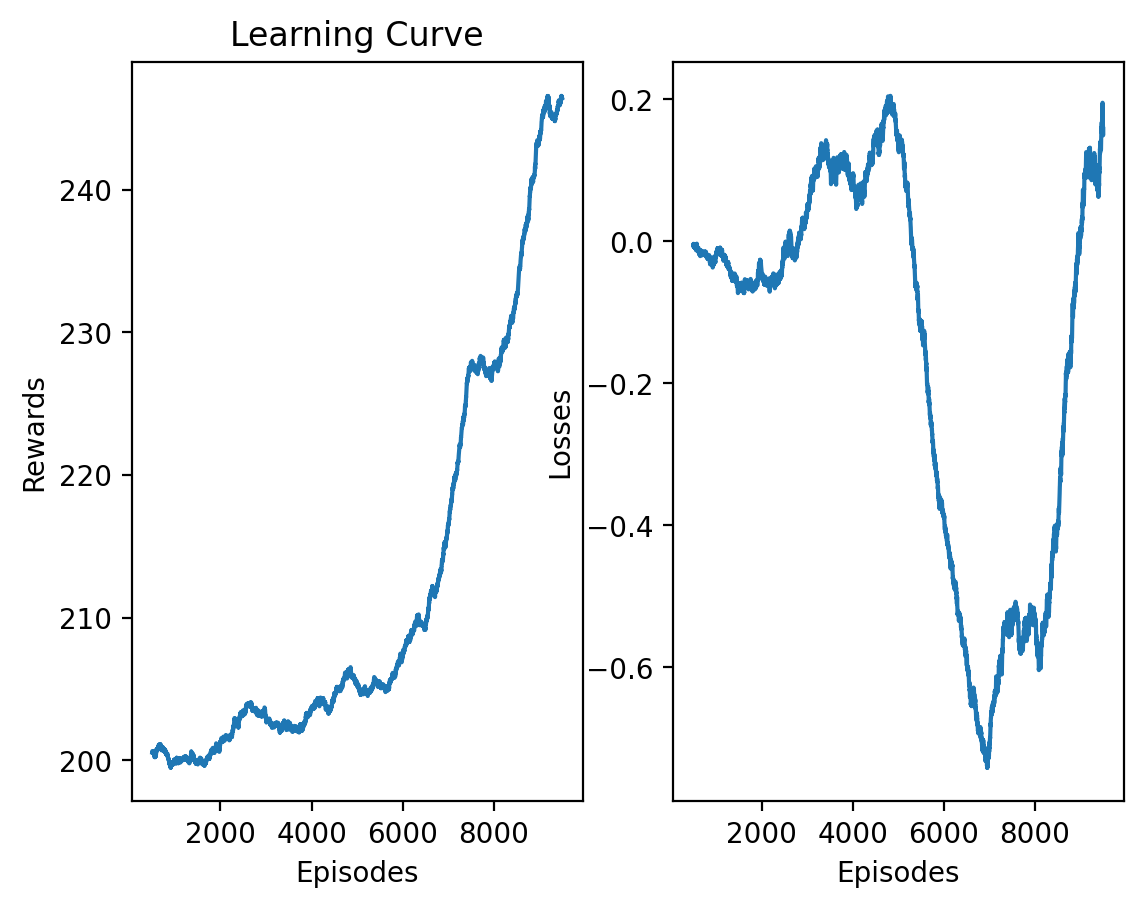

In [ ]:
# %% PLOT LEARNING CURVE
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='all', dpi=200)

## smooth rewards if necessary (moving average)
smoothing_window = n_episodes // 10
smoothed_rewards = np.convolve(score_history, np.ones(smoothing_window)/smoothing_window, mode='valid')
smoothed_losses = np.convolve(pg_losses, np.ones(smoothing_window)/smoothing_window, mode='valid')
episodes = np.array(range(n_episodes))[smoothing_window//2:-smoothing_window//2+1]

ax1.plot(episodes, smoothed_rewards)

ax1.set_title("Learning Curve")
ax1.set_xlabel("Episodes")
ax1.set_ylabel("Rewards")

ax2.plot(episodes, smoothed_losses)
ax2.set_xlabel("Episodes")
ax2.set_ylabel("Losses")

Now, we will try to move from REINFORCE to A2C. This will involve making two changes to the code which you will have heard about in Aniruddh's lecture:

1. Moving from REINFORCE to Actor-Critic: This will involve introducing a second network that represents value
2. From Monte Carlo to Advantage Learning: This means that instead of performing updates at the end of an episode (or a batch of episodes), we can now perform bootstrapping updates at an individual timestep based on the agent's value of estimate

By combining these two steps, we will have successfully implemented the A2C algorithm.

We begin by building a second network whose task will be to build a representation of value:

In [ ]:
class CriticRNN(nn.Module):

    def __init__(self, n_inputs, hidden_size=32):

        super().__init__()
        self.n_inputs = n_inputs
        self.hidden_size = hidden_size
        torch.manual_seed(1)
        self.initialize_model()

    def initialize_model(self):

        self.lstm = nn.LSTMCell(self.n_inputs, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, 1)

    def forward(self, x, lstm_hidden = None):

        if lstm_hidden is None:
            lstm_h, lstm_c = self.lstm(x)
        else:
            lstm_h, lstm_c = self.lstm(x, lstm_hidden)
        out = self.out(lstm_h)

        return out, (lstm_h, lstm_c)

We now expand our agent to include this network, and update the learning algorithm to learn on every step

In [ ]:

class Agent:

    def __init__(self, n_actions, n_states, hidden_size, learning_rate, gamma = 0.99):

        self.gamma = gamma
        self.n_actions = n_actions
        self.actor= PolicyRNN(n_actions, n_states, hidden_size['actor'])
        self.critic = CriticRNN(n_states, hidden_size['critic'])
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr = learning_rate['actor'])
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr = learning_rate['critic'])
        self.history = []

    def reset(self):
        self.actor_hidden = None
        self.critic_hidden = None
        self.current_state_value = None

    def choose_action(self, observation):
        ''' Selects an action by using the policy network. Can you fill this on?

        Arguments
        ---------
        observation : np.array [1, n_features]

        Returns
        -------
        action : int between 0 and n_action - 1
        '''


        #### EXERCISE 1: Selection of action
        #### This works the same way as it did in the REINFORCE part, except instead of appending the log probability of the selected action
        #### to a list, we just save the fitted Categorical object so that we can use it to recover the logit later (since we are going step-by-step)
        #### Save the Categorical object to self.action_probs

        #### YOUR CODE HERE

        state = torch.tensor(observation, dtype=torch.float32)
        log_probs, self.actor_hidden = self.actor(state, self.actor_hidden)
        self.action_probs = Categorical(logits = log_probs)
        action = self.action_probs.sample()
        return action.detach().numpy().item()

    def store_transition(self, observation, action, reward, next_observation):
        self.history.append((observation, action, reward, next_observation))

    def learn(self, done):

        current_state, current_action,current_reward, next_state = self.history[-1]
        current_state = torch.tensor(current_state, dtype = torch.float32)
        next_state = torch.tensor(next_state, dtype = torch.float32)
        current_reward = torch.tensor(current_reward, dtype = torch.float32)
        current_action = torch.tensor(current_action, dtype = torch.float32)

        if self.current_state_value is None:
          self.current_state_value, self.critic_hidden = self.critic(current_state, self.critic_hidden)
          #print(self.current_state_value)

        next_state_value, next_critic_hidden = self.critic(next_state, self.critic_hidden)
        #next_state_value = 0


        ### EXERCISE 2: Calculate the TD Error from current_reward, next_state_value, and current_state_value
        ### (keeping in mind that you need to exclude next_state_value if you are in the last trial, i.e. if done is True)
        ### Save the result to td_error

        ### YOUR CODE HERE

        td_error = (current_reward + self.gamma*next_state_value*(1- int(done))) - self.current_state_value

        log_probs = self.action_probs.log_prob(current_action)

        ### EXERCISE 3: Calculate the separate actor and critic loss from the td_error and log_probs of chosen action
        ### Save the losses in actor_loss and critic_loss

        ### YOUR CODE HERE

        actor_loss = -td_error * log_probs
        critic_loss = td_error ** 2

        loss = actor_loss+critic_loss
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        #loss.backward(retain_graph=True)
        loss.backward()
        self.actor_optimizer.step()
        self.critic_optimizer.step()

        self.current_state_value = next_state_value.detach()
        self.critic_hidden = next_critic_hidden

        self.actor_hidden = (self.actor_hidden[0].detach(), self.actor_hidden[1].detach())
        self.critic_hidden = (self.critic_hidden[0].detach(), self.critic_hidden[1].detach())

        return actor_loss.item(), critic_loss.item()

We now make the needed modifications to the training loop. Because we are updating on every time step we use a smaller number of episodes

In [ ]:
# %% PARAMETERS
n_steps = 20
n_episodes = 20000
#n_episodes = 100
batch_size = 50
hidden_size = 16
gamma = 0.99 #discount factor

# %% INITIALIZATIONS
env = TwoArmedGaussianBandit(10, 0.1, n_steps)

hidden_size = dict()
learning_rate = dict()

hidden_size['actor'] = 16
hidden_size['critic'] = 16

learning_rate['actor'] = 1e-3
learning_rate['critic'] = 1e-3

agent = Agent(n_actions = 2, n_states = 1, hidden_size = hidden_size,  learning_rate = learning_rate, gamma = gamma)
score_history = []
actor_losses = []
critic_losses = []

for i in range(n_episodes):

    done = False
    score = 0
    observation = env.reset()
    agent.reset()
    mean_actor_loss_in_episode = 0
    mean_critic_loss_in_episode = 0
    step_count = 0
    while not done:

        ### EXERCISE 4: The next functions encode the interactions between agent and the environment.
        ### The agent needs to choose an action, interact with the environment, store the transition,
        ### and finally update the observation and score variables, and finally - because here we are using TD -
        ### perform the learning update on every step (unlike the REINFORCE code above)!
        ### Most of these pieces already exist in the module functions - can you put them all together?

        ### YOUR CODE HERE

        action = agent.choose_action(observation)
        next_observation, reward, done, info = env.step(action)
        agent.store_transition(observation, action, reward, next_observation)
        observation = next_observation
        score += reward

        actor_loss, critic_loss = agent.learn(done)

        ### To plot the learning curve etc
        mean_actor_loss_in_episode += actor_loss
        mean_critic_loss_in_episode += critic_loss
        step_count += 1

    mean_actor_loss_in_episode = mean_actor_loss_in_episode / step_count
    mean_critic_loss_in_episode = mean_critic_loss_in_episode / step_count

    score_history.append(score)
    actor_losses.append(mean_actor_loss_in_episode)
    critic_losses.append(mean_critic_loss_in_episode)
    avg_score = np.mean(score_history[-50:])

    if i % (n_episodes // 10) == 0:
      print('episode ', i, 'score  %.1f' % score, 'avg score %.1f' % avg_score)

episode  0 score  -37.8 avg score -37.8
episode  2000 score  200.7 avg score 77.8
episode  4000 score  139.4 avg score 54.9
episode  6000 score  -1.6 avg score -2.6
episode  8000 score  -19.8 avg score 129.8
episode  10000 score  121.0 avg score 120.3
episode  12000 score  -119.8 avg score 115.2
episode  14000 score  158.9 avg score 114.6
episode  16000 score  -121.3 avg score 47.3
episode  18000 score  181.5 avg score 30.2


Text(0, 0.5, 'Critic Losses')

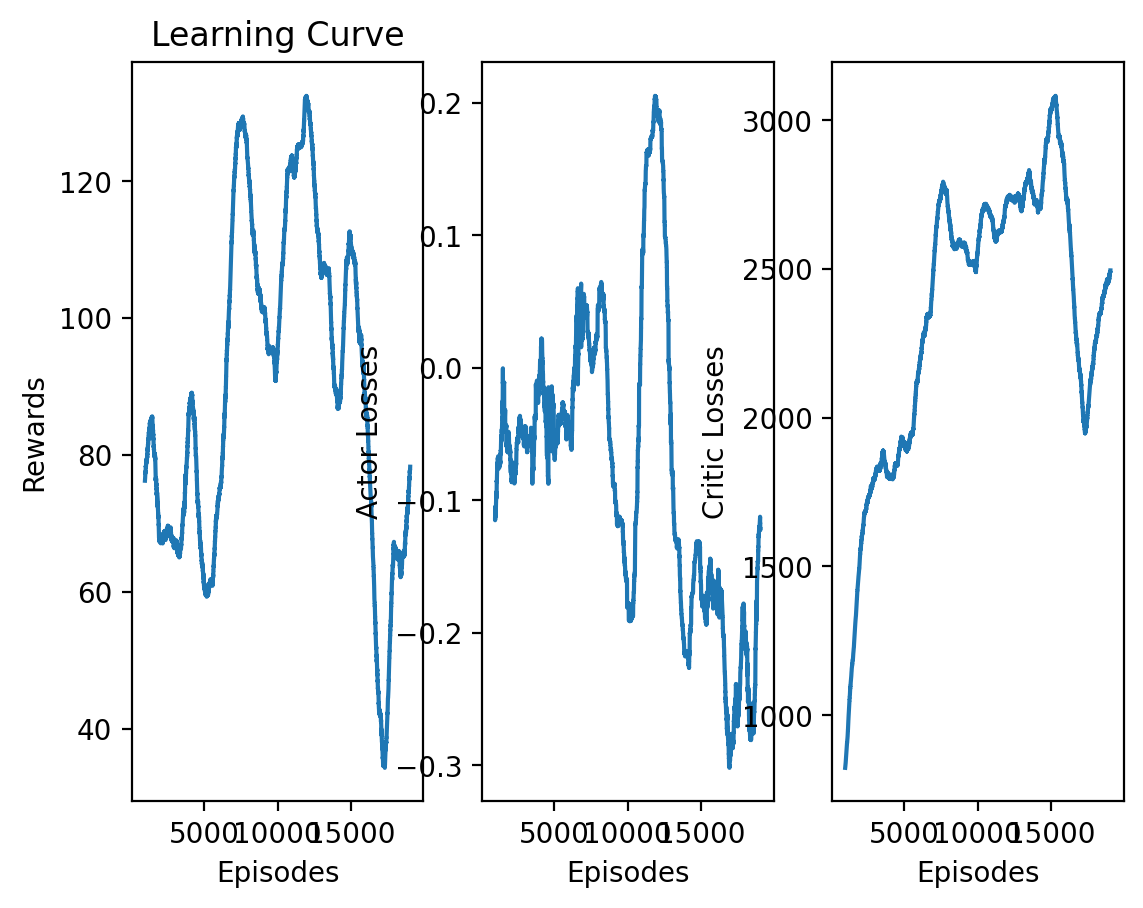

In [ ]:
# %% PLOT LEARNING CURVE
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='all', dpi=200)

## smooth rewards if necessary (moving average)
smoothing_window = n_episodes // 10
smoothed_rewards = np.convolve(score_history, np.ones(smoothing_window)/smoothing_window, mode='valid')
smoothed_actor_losses = np.convolve(actor_losses, np.ones(smoothing_window)/smoothing_window, mode='valid')
smoothed_critic_losses = np.convolve(critic_losses, np.ones(smoothing_window)/smoothing_window, mode='valid')
episodes = np.array(range(n_episodes))[smoothing_window//2:-smoothing_window//2+1]

ax1.plot(episodes, smoothed_rewards)

ax1.set_title("Learning Curve")
ax1.set_xlabel("Episodes")
ax1.set_ylabel("Rewards")

ax2.plot(episodes, smoothed_actor_losses)
ax2.set_xlabel("Episodes")
ax2.set_ylabel("Actor Losses")

ax3.plot(episodes, smoothed_critic_losses)
ax3.set_xlabel("Episodes")
ax3.set_ylabel("Critic Losses")

As you can see, the A2C network learns significantly faster than the REINFORCE one (counted per number of episodes)!